In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [4]:
import sys
sys.path.append('../../src')

In [ ]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
adata

AnnData object with n_obs × n_vars = 89296 × 2116
    obs: 'sample', 'cell_type', 'secondary_annot', 'cell_type_int'
    uns: 'cell_type_colors', 'neighbors', 'umap', 'cell_thresholds'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

### Encode and impute

In [6]:
cell_threshes = pd.read_csv('/ix/djishnu/shared/djishnu_kor11/commot_outputs/mouse_lymph1_visiumHD_cell_threshes.csv', index_col=0)

adata.obs.index = adata.obs.index.astype(str)
cell_threshes.index = cell_threshes.index.astype(str)

np.where(cell_threshes > 0, 1, 0).sum().sum() / (cell_threshes.shape[0] * cell_threshes.shape[1])

0.21525888394897594

In [7]:
adata.uns['cell_thresholds'] = cell_threshes.loc[adata.obs.index]

In [5]:
from spaceoracle.tools.network import encode_labels

adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_int'] = adata.obs['cell_type'].apply(
    lambda x: encode_labels(adata.obs['cell_type'], reverse_dict=True)[x])

2025-06-17 17:00:20.918605: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [ ]:
from spaceoracle.oracles import BaseTravLR

pcs = BaseTravLR.perform_PCA(adata)
BaseTravLR.impute_clusterwise(adata)


In [8]:
adata.write_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')

### Run CO

In [5]:
adata.X = adata.layers['raw_count'].copy()

ccr4 = adata[:, 'Ccr4'].to_df()
prdm1 = adata[:, 'Prdm1'].to_df()

ccr4_pos = ccr4[ccr4['Ccr4'] > 0]
prdm1_pos = prdm1[prdm1['Prdm1'] > 0]  # Fixed column name from 'Ccr4' to 'Prdm1'

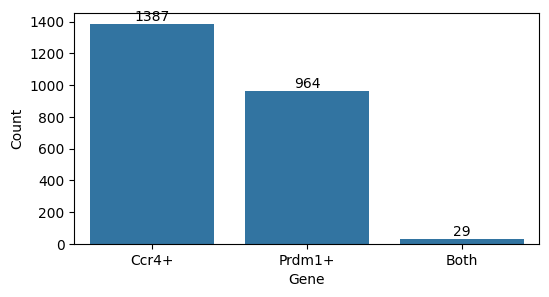

In [6]:
import seaborn as sns 

plt.figure(figsize=(6,3))
ax = sns.barplot(
    data=pd.DataFrame({
        'Gene': ['Ccr4+', 'Prdm1+', 'Both'],
        'Count': [
            len(ccr4_pos),
            len(prdm1_pos),
            len(ccr4_pos.index.intersection(prdm1_pos.index))
        ]
    }),
    x='Gene',
    y='Count'
)

# Add count labels on top of bars
for i, v in enumerate(ax.patches):
    ax.text(v.get_x() + v.get_width()/2, v.get_height(), 
            str(int(v.get_height())), 
            ha='center', va='bottom')


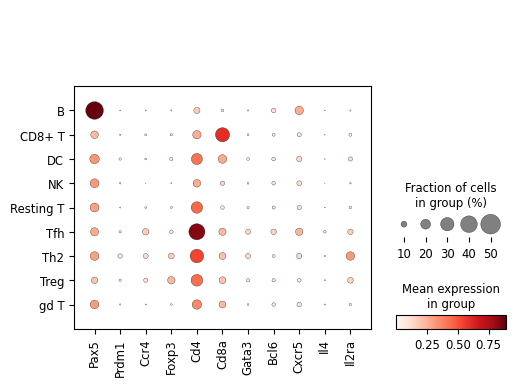

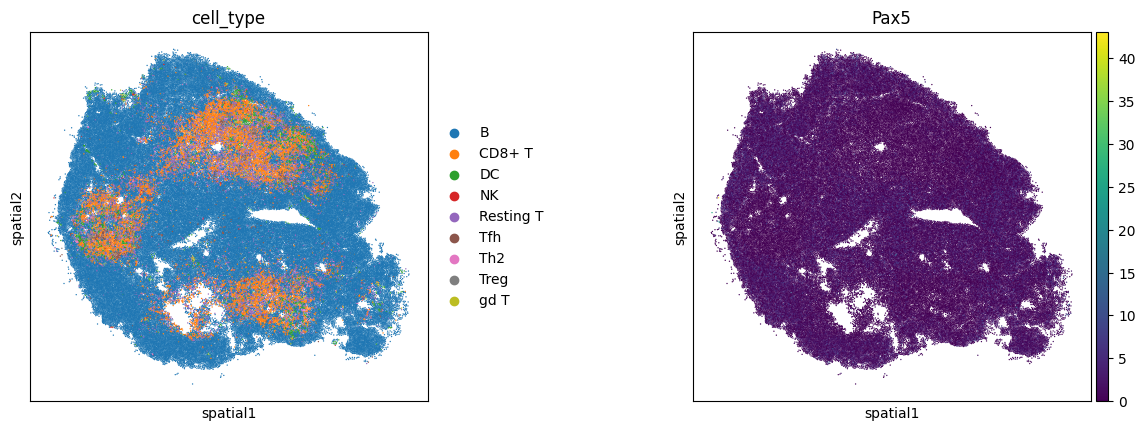

cell_type
B            67597
CD8+ T        9148
Resting T     6991
DC            1807
Treg          1607
Tfh           1060
Th2            433
gd T           362
NK             291
Name: count, dtype: int64

In [7]:
var_names = ['Pax5', 'Prdm1','Ccr4', 'Foxp3', 'Cd4', 'Cd8a', 'Gata3', 'Bcl6', 'Cxcr5', 'Il4', 'Il2ra']

sc.pl.dotplot(adata, 
    var_names=var_names, 
    swap_axes=False,
    groupby='cell_type'
)

sc.pl.spatial(adata, color=['cell_type', 'Pax5'], spot_size=20)
adata.obs['cell_type'].value_counts()

In [8]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

1 package does not meet CellOracle requirement.
 Your jupyter version is not_found. Please install jupyter


### Get GRN

In [9]:
adata

AnnData object with n_obs × n_vars = 89296 × 2116
    obs: 'sample', 'cell_type', 'secondary_annot', 'cell_type_int'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

2025-06-17 22:19:07.220890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-17 22:19:07.808124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/

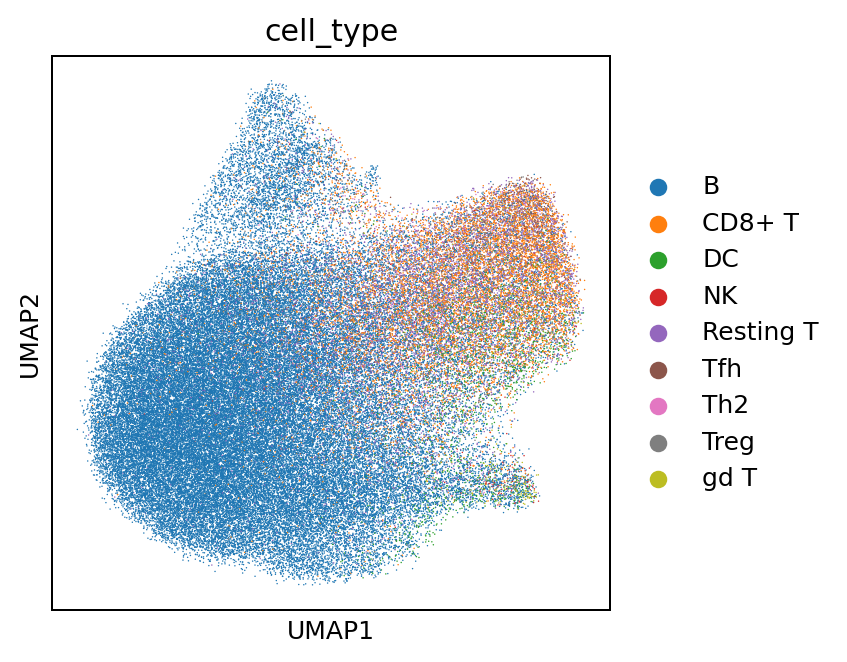

In [13]:
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')

In [14]:
adata.write_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')

In [15]:
%matplotlib inline

oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [16]:
base_GRN = co.data.load_mouse_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


In [17]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=5,
    verbose_level=1
)

100%|██████████| 9/9 [39:57<00:00, 266.39s/it]  


CPU times: user 28min 29s, sys: 30 s, total: 28min 59s
Wall time: 40min 10s


In [18]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=5, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/9 [00:00<?, ?it/s]

In [19]:
import pickle

with open('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [20]:
links.to_hdf5(file_path="/ix/djishnu/shared/djishnu_kor11/co_objects/mouse_lymph1_visiumHD.celloracle.links")
oracle.to_hdf5("/ix/djishnu/shared/djishnu_kor11/co_objects/mouse_lymph1_visiumHD.celloracle.oracle")

### Perturb

In [21]:
oracle = co.load_hdf5("/ix/djishnu/shared/djishnu_kor11/co_objects/mouse_lymph1_visiumHD.celloracle.oracle")
links = co.load_hdf5("/ix/djishnu/shared/djishnu_kor11/co_objects/mouse_lymph1_visiumHD.celloracle.links")

In [22]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [23]:
oracle.cluster_column_name

'cell_type'

In [24]:
# oracle.adata.uns['draw_graph'] = {}
# oracle.adata.uns['draw_graph']["params"] = {}
# oracle.adata.uns['draw_graph']["params"]["layout"] = 'X_umap'

# oracle.adata.obs['draw_graph_X_umap'] = adata.obsm['X_umap']

In [25]:
goi='Pax5'

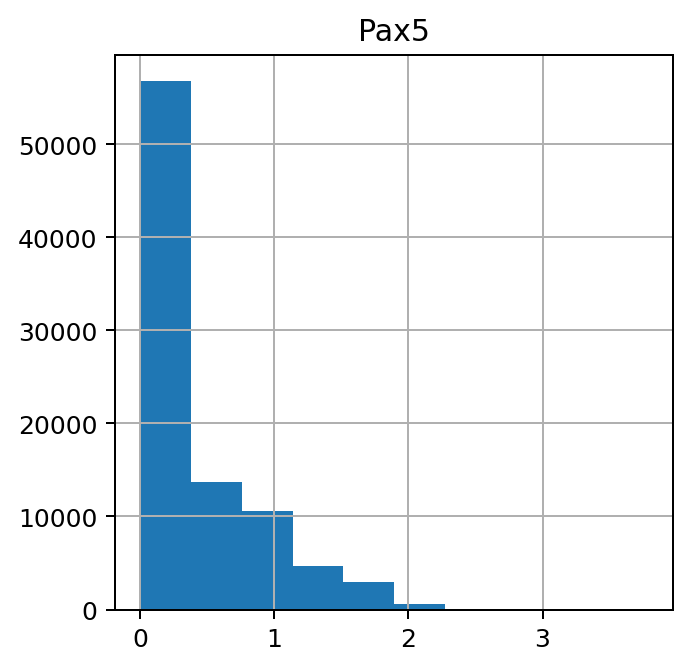

In [26]:
sc.get.obs_df(oracle.adata, keys=[goi], layer="normalized_count").hist()
plt.show()

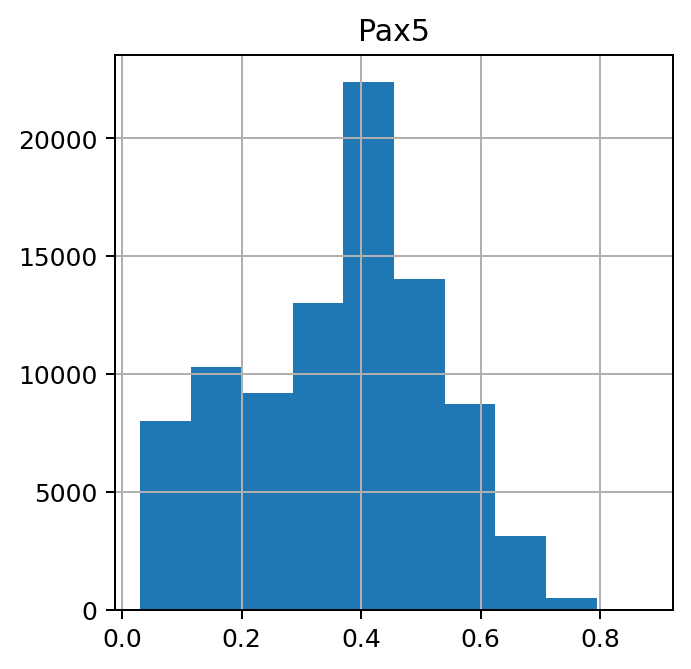

In [27]:
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [28]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

: 

In [33]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

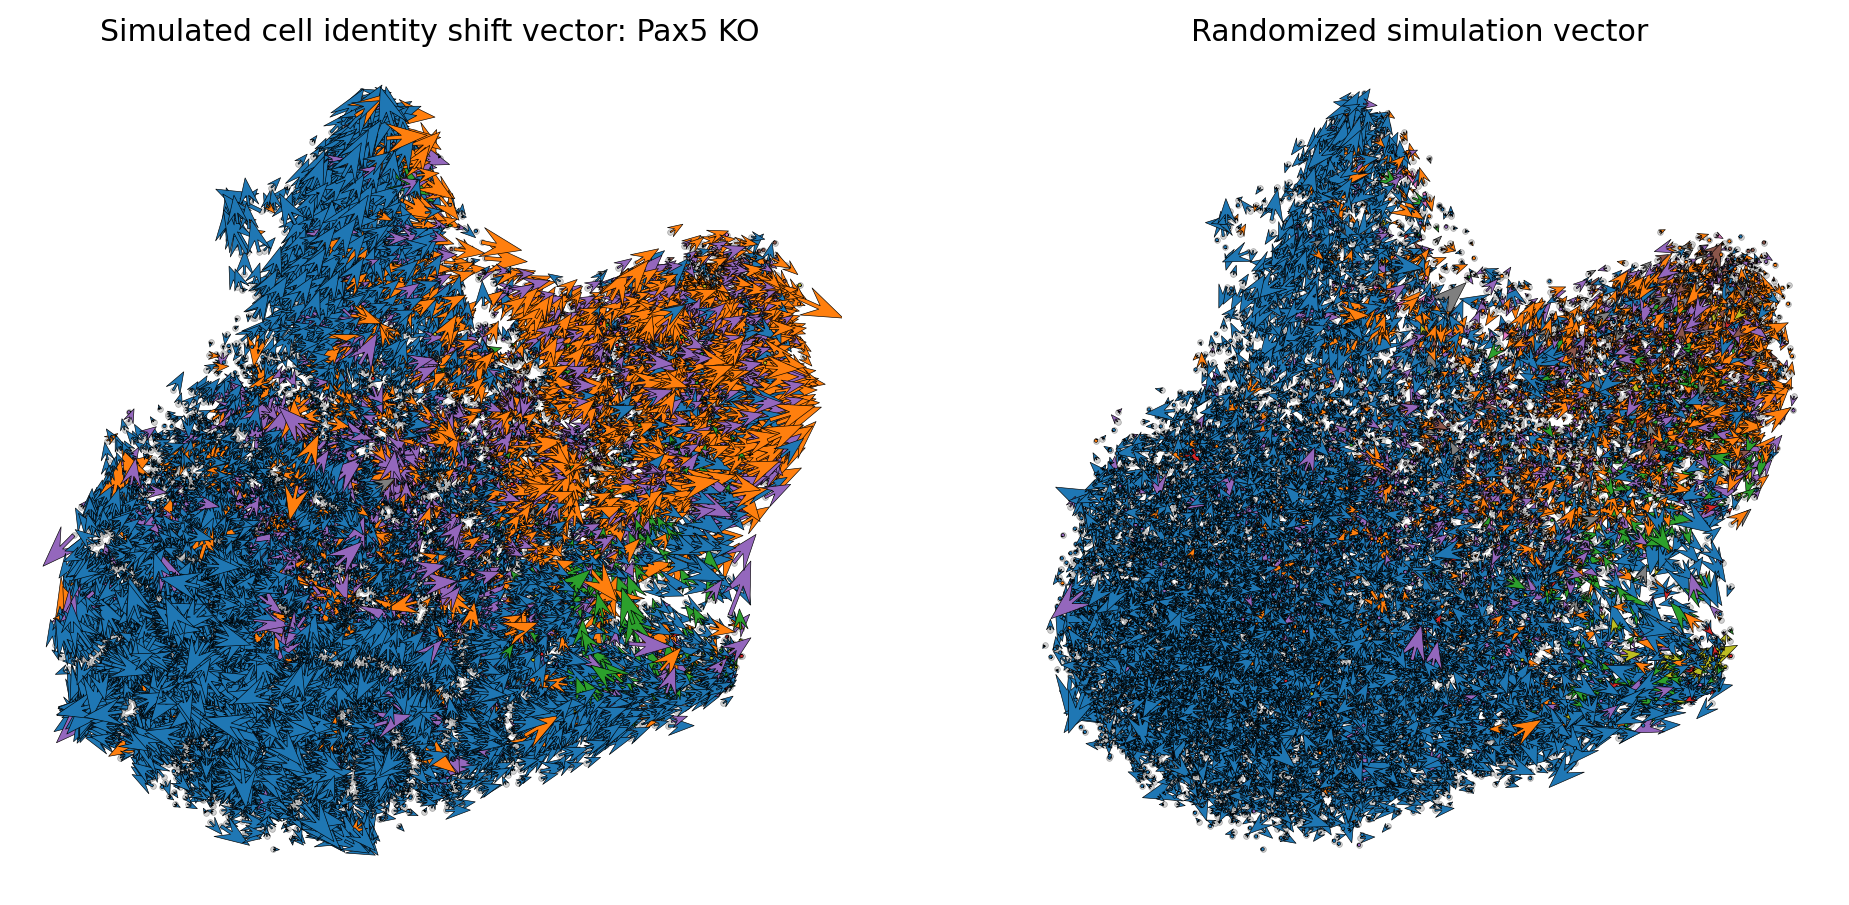

In [34]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 20
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [35]:
# n_grid = 40 is a good starting value.
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

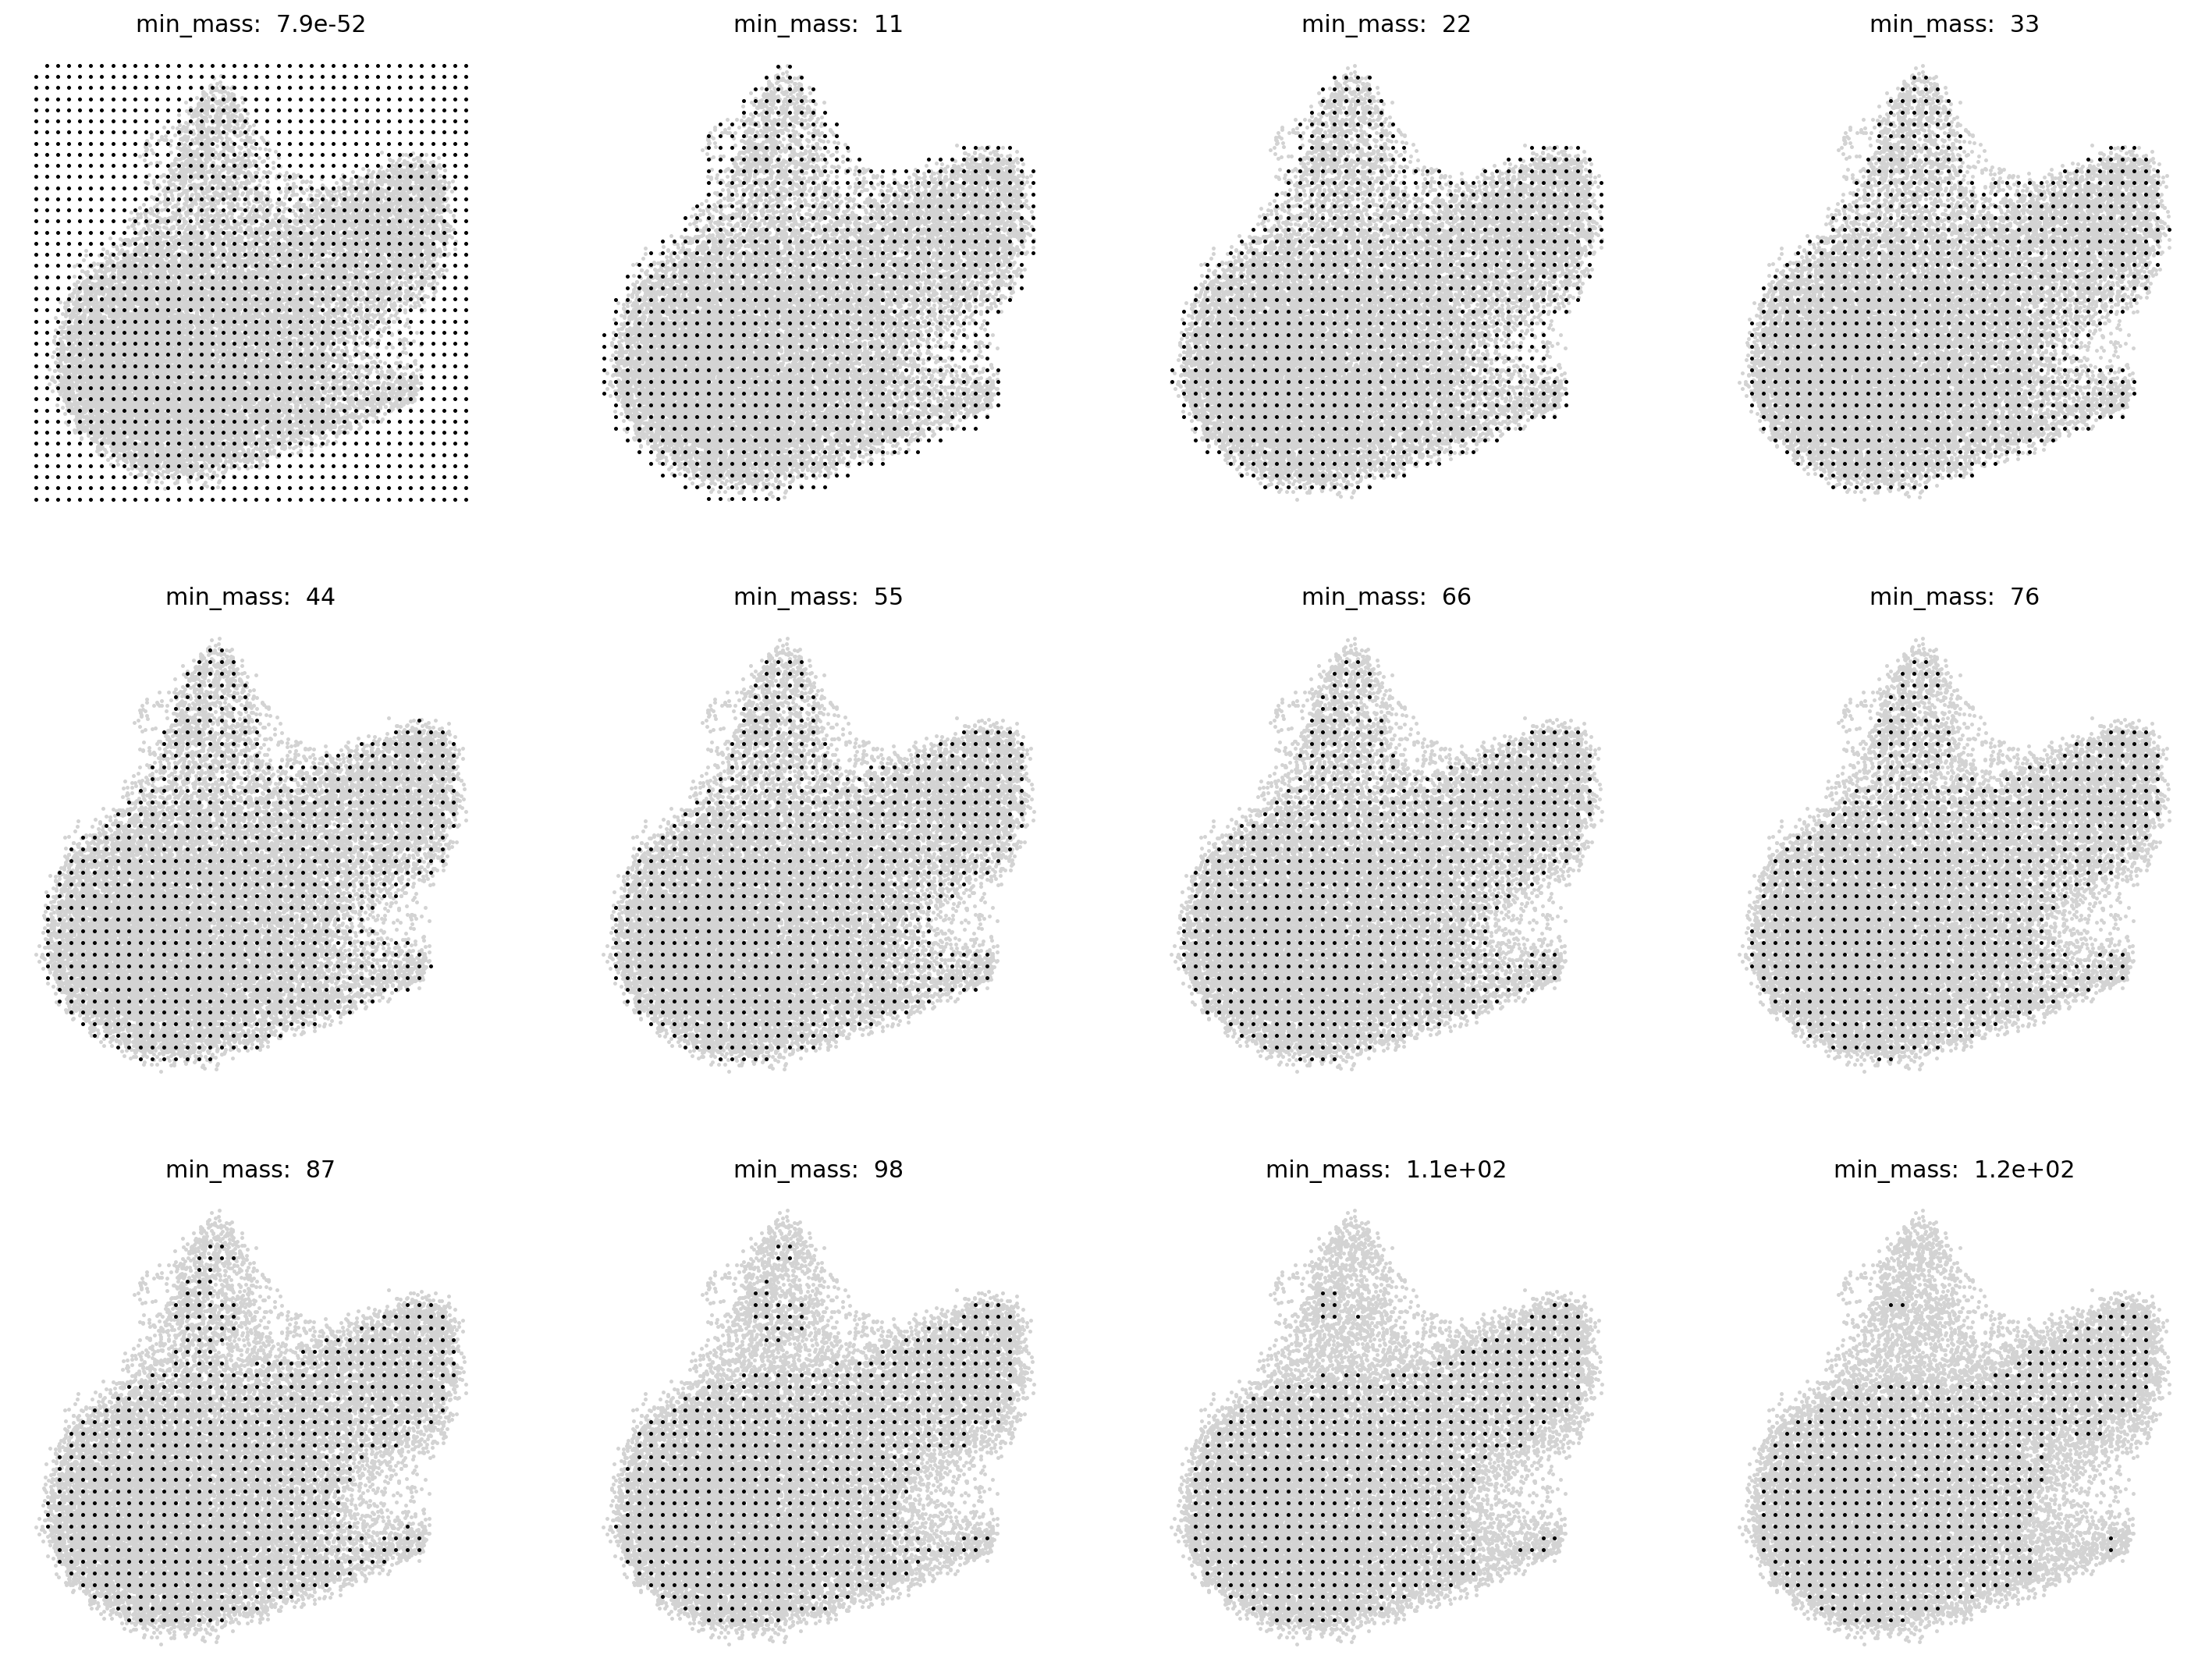

In [36]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

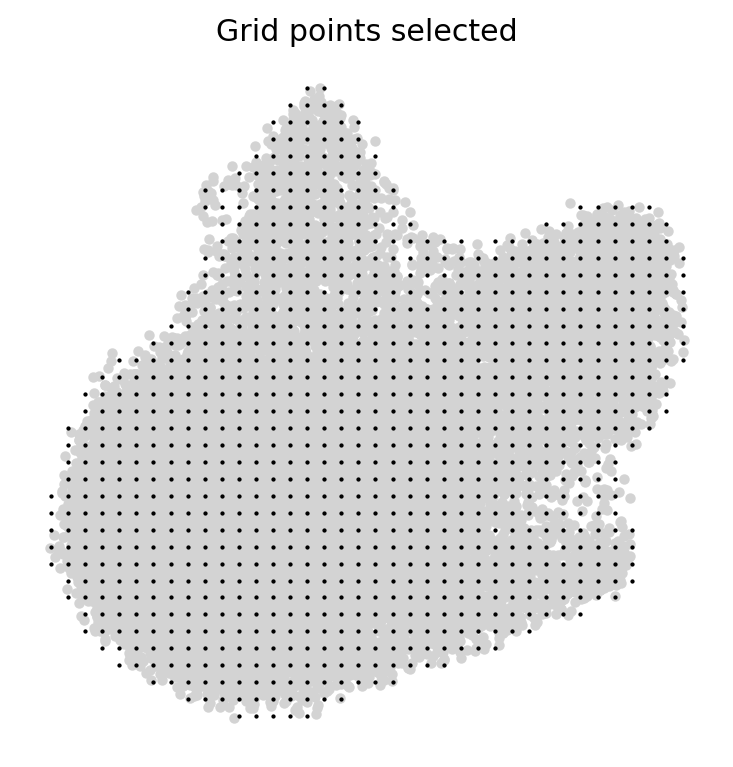

In [37]:
min_mass = 16
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

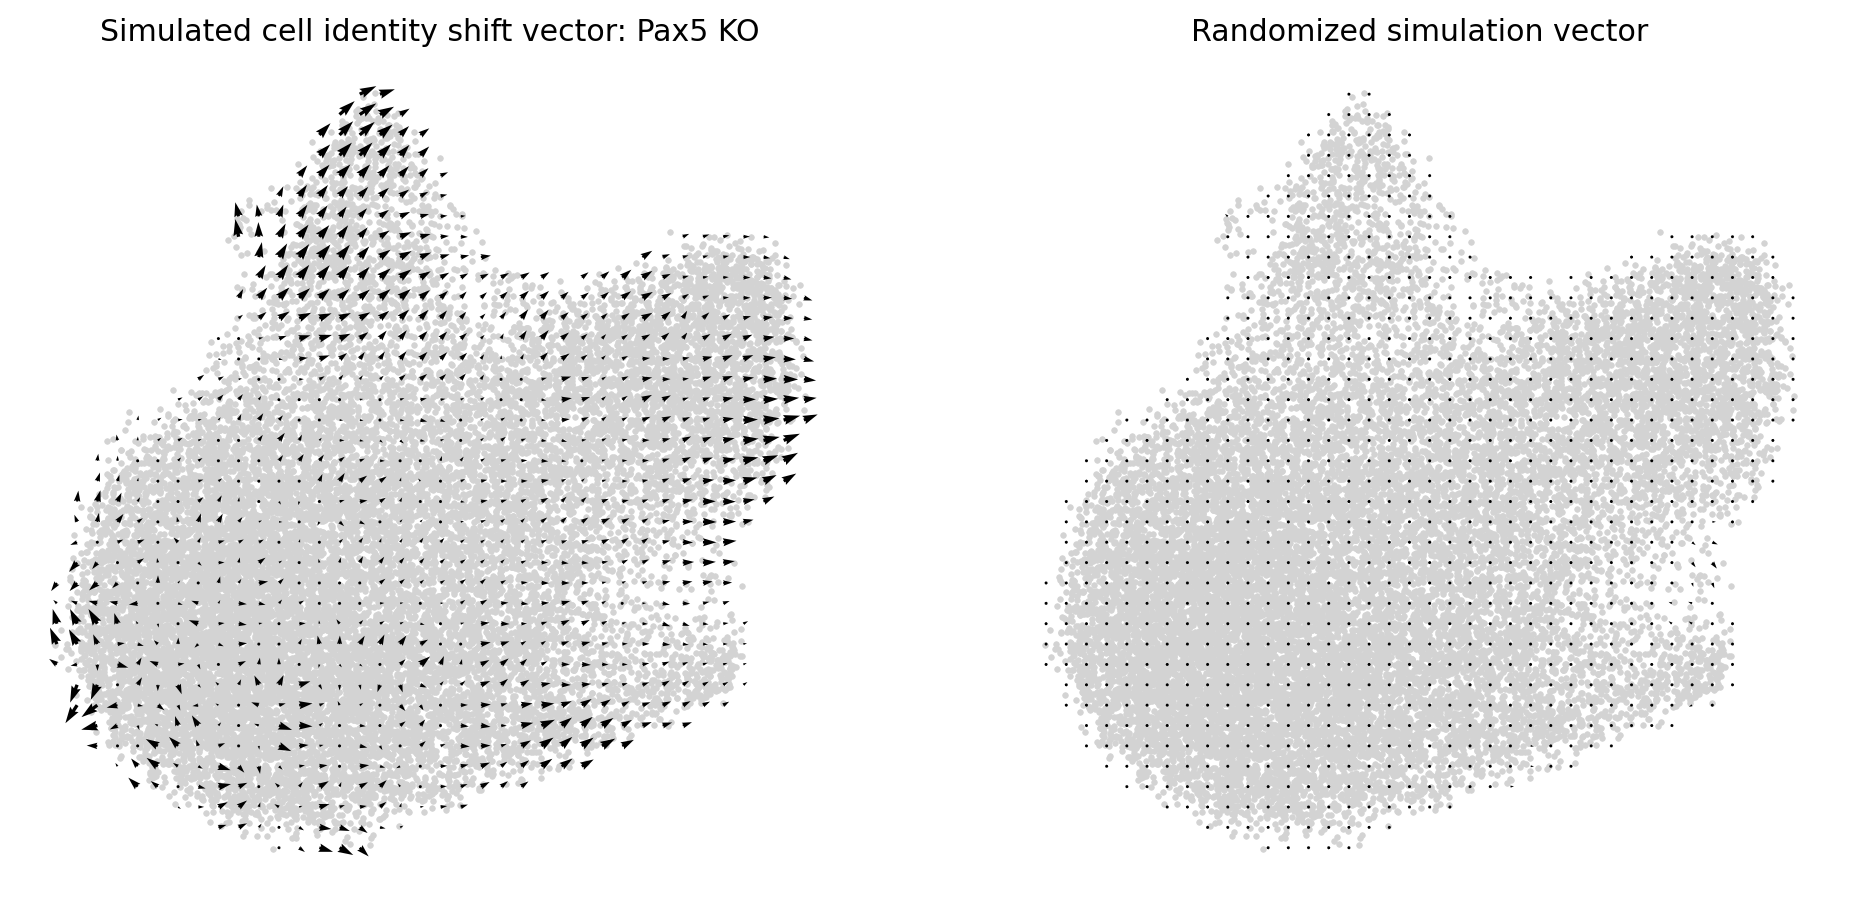

In [38]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 30
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

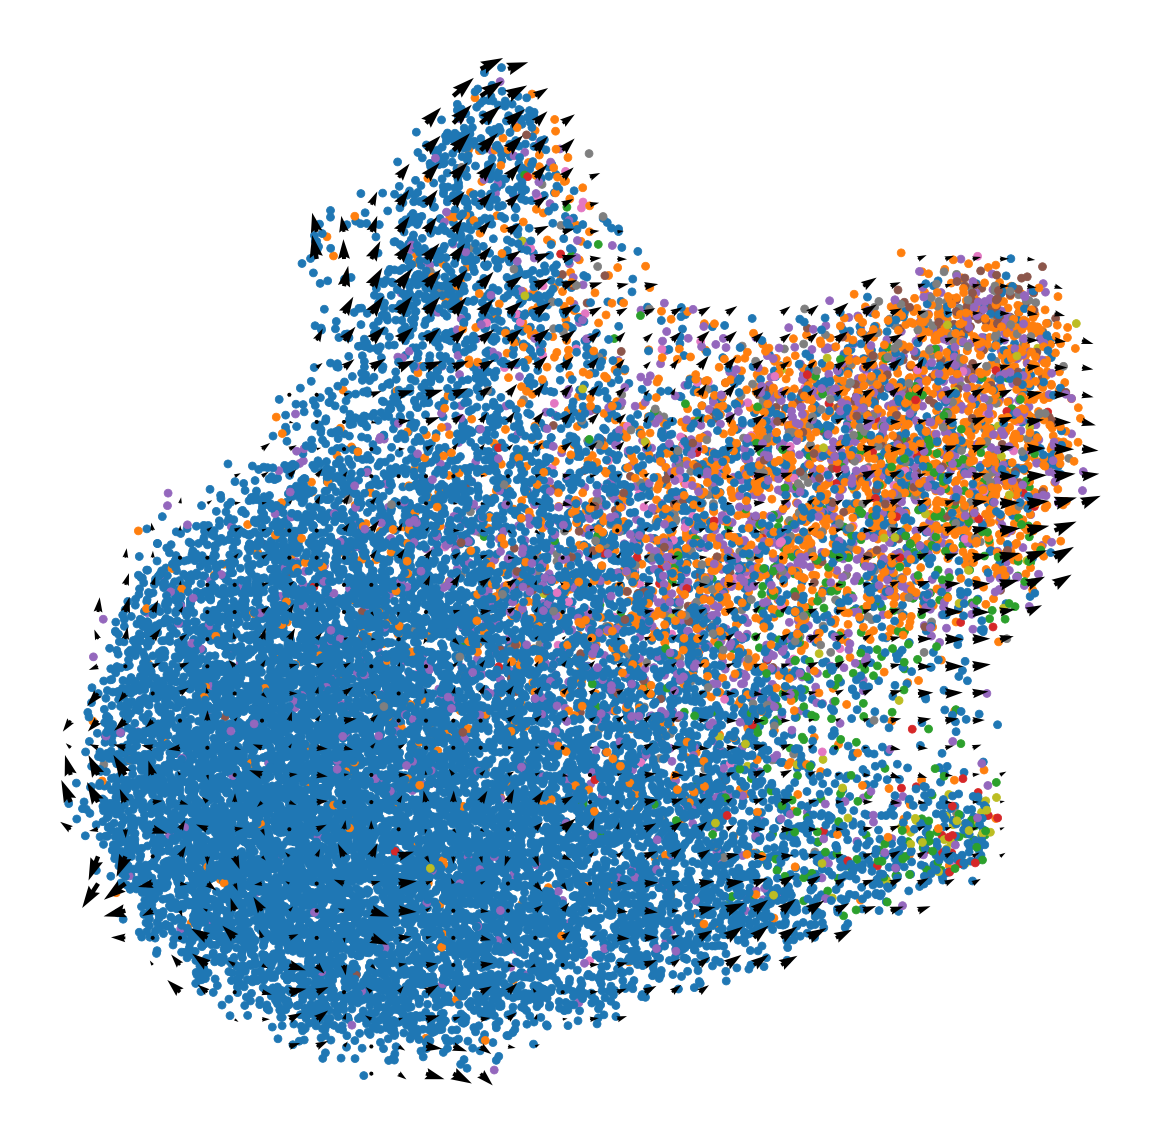

In [39]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)